In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Physics-Informed Neural Networks (PINNs) - Forward Problems

We can use PINNs to solve forward problems in place of traditional numerical methods.
This is not recommended, as PINNs are not yet as efficient as traditional numerical methods.
But, it is a good way to learn how to use PINNs and to understand their limitations.

## The toy problem - Steady-state heat equation

We are going to solve a Poisson's equation with a source term:

$$
\begin{aligned}
    -k\Delta u(x, y) &= f(x, y) \quad \text{in} \quad \Omega = [0, L_x]\times [0, L_y], \\
    u(x, y) &= 0 \quad \text{on} \quad \partial \Omega.
\end{aligned}
$$

## Making an exact solution
We will use a common trick to construct an exact solution. We will use the following function:

$$
u(x, y) = u_0 \sin^2(\pi x/L_x) \sin^2(10\pi y/L_y).
$$

The boundary conditions are satisfied by construction. The source term is:

In [2]:
import sympy

xs, ys, ks, u0s, Lxs, Lys = sympy.symbols('x y k u_0 L_x L_y')

us = u0s * sympy.sin(sympy.pi * xs / Lxs) ** 2 * sympy.sin(sympy.pi * ys / Lys) ** 2
fs = -ks * (sympy.diff(us, xs, 2) + sympy.diff(us, ys, 2))
sympy.simplify(fs)

2*pi**2*k*u_0*(-L_x**2*sin(pi*x/L_x)**2*cos(2*pi*y/L_y) - L_y**2*sin(pi*y/L_y)**2*cos(2*pi*x/L_x))/(L_x**2*L_y**2)

This is a common trick for constructing exact solutions. Remember it!

Let's use the following parameters:

In [3]:
u0 = 500 # degrees Kelvin
k = 10.0 # thermal conductivity in W/mK
Lx = 0.1 # meters
Ly = 1.0 # meters

## Enforcing the boundary conditions

We are going to solve this boundary value problem using PINNS.
Our model will be:

$$
u(x,y) = x(1-x)y(1-y)\text{MLP}(x, y),
$$

where $\text{MLP}(x, y)$ is a multi-layer perceptron, and $x(1-x)y(1-y)$ is a polynomial that satisfies the boundary conditions.
This is also a common trick for enforcing boundary conditions in PINNS.

## Multi-layer perceptron
We will be using a simple multi-layer perceptron to represent the solution of a PDE. The architecture of the network is given by:

$$
\text{MLP}(\mathbf{x}) = z^{(L)},
$$

where 

$$
z^{(0)} = \mathbf{x} = (x,y), \quad z^{(l)} = g^{(l)}(W^{(l)}z^{(l-1)} + b^{(l)}), \quad l=1,\ldots,L-1,
$$

The terms $W^{(l)}$ and $b^{(l)}$ are the weights and biases of the $l$-th layer, and $g^{(l)}$ is the activation function of the $l$-th layer.
The parameters $\theta$ are the weights and biases of the network:

$$
\theta = \left\{\left(W^{(l)}, b^{(l)}\right)\right\}_{l=1}^L.
$$

For PINNS applications, it is recommended that:
+ We use the tanh activation function all layers.
+ We use 128 to 512 neurons per layer.
+ We use 3 to 5 layers.
+ Use the Glorot initialization (this is the default in `equinox`).

Let's make the model:

In [72]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as jrandom

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
# MLP parameters
width_size = 128
depth = 4
mlp = eqx.nn.MLP(2, 1, width_size, depth, jnp.tanh, key=subkey)

# This is the parameterization of the solution that satisfies the boundary conditions
u_hat = lambda x, y, mlp: x * (Lx - x) * y * (Ly - y) * mlp(jnp.array([x, y]))[0]

Let's see how it looks like before we train it:

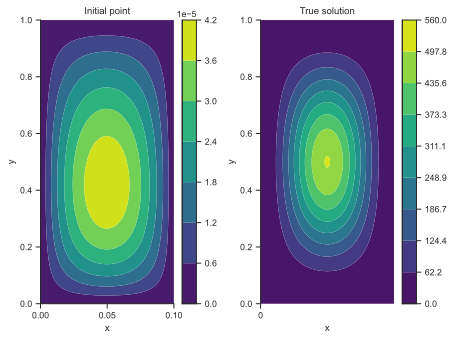

In [73]:
from jax import vmap

v_u_hat = eqx.filter_jit(vmap(u_hat, in_axes=(0, 0, None)))

x = jnp.linspace(0, Lx, 100)
y = jnp.linspace(0, Ly, 100)
X, Y = jnp.meshgrid(x, y)
u_pred = v_u_hat(X.flatten(), Y.flatten(), mlp).reshape(X.shape)

# the true solution for comparison
u_true = u0 * jnp.sin(jnp.pi * X / Lx) ** 2 * jnp.sin(jnp.pi * Y / Ly) ** 2

fig, ax = plt.subplots(1,2)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Initial point')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true, cmap='viridis', levels=jnp.linspace(0, 560, 10))
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('True solution')
sns.despine(trim=True)
plt.tight_layout();

## Setting up the loss function

We are going to train this by minimizing the following loss function:

$$
\mathcal{L}(\theta) = \int_{\Omega} \left[ \Delta u(x, y) + f(x, y) \right]^2 \, dx \, dy.
$$

The first step, is to turn the loss function into an expectation.
Construct the random variable $\mathbf{X} = (X,Y)$ uniformly distributed in $\Omega$.
Then, the loss function can be written as:

$$
\mathcal{L}(\theta) = |\Omega|\mathbb{E}\left[ \left[ \Delta u(\mathbf{X}) + f(\mathbf{X}) \right]^2 \right].
$$

Notice that the volume of $\Omega$, $\Omega|$, appears as a constant factor.
Where did it come from?
Recall the probability density function of $\mathbf{X}$ is:

$$
p(\mathbf{x}) = \frac{1}{|\Omega|} \quad \text{if} \quad \mathbf{x} \in \Omega, \quad \text{and} \quad 0 \quad \text{otherwise}.
$$

So:

$$
\int_{\Omega} \left[ \Delta u(\mathbf{x}) + f(\mathbf{x}) \right]^2 \, d\mathbf{x}
= \int_{\Omega} \left[ \Delta u(\mathbf{x}) + f(\mathbf{x}) \right]^2 |\Omega|p(\mathbf{x}) \, d\mathbf{x}
= |\Omega|\mathbb{E}\left[ \left[ \Delta u(\mathbf{X}) + f(\mathbf{X}) \right]^2 \right].
$$

We can approximate this expectation by sampling a finite number of points from $\Omega$ and averaging the loss function over these points.
This is what we will be doing in each iteration of the training process.

In [74]:
from jax import grad

# First order derivatives
u_x = grad(u_hat, argnums=0)
u_y = grad(u_hat, argnums=1)

# Second order deerivatives
u_xx = grad(u_x, argnums=0)
u_yy = grad(u_y, argnums=1)

# The Laplacian
D2_u = lambda x, y, mlp: u_xx(x, y, mlp) + u_yy(x, y, mlp)

# The source term
source_term = lambda x, y: 2.0 * jnp.pi ** 2 * k * u0 * (
    -Lx ** 2 * jnp.sin(jnp.pi * x / Lx) ** 2 * jnp.cos(2.0 * jnp.pi * y / Ly)
    -Ly ** 2 * jnp.sin(jnp.pi * y / Ly) ** 2 * jnp.cos(2.0 * jnp.pi * x / Lx)
) / (Lx ** 2 * Ly ** 2)

# The PDE residual (vectorize)
pde_residual = vmap(
    lambda x, y, mlp: D2_u(x, y, mlp) + source_term(x, y),
    in_axes=(0, 0, None))

# Finally the loss function:
loss = lambda mlp, x, y: Lx * Ly * jnp.mean(jnp.square(pde_residual(x, y, mlp)))

## Training the model

We will use the ADAM optimizer with standard parameters. This is the training algorithm:

In [75]:
def train(
        loss,
        mlp,
        key,
        optimizer,
        Lx=1.0,
        Ly=1.0,
        num_collocation_residual=512,
        num_iter=10_000,
        freq=1,
    ):

    @eqx.filter_jit
    def step(opt_state, mlp, xs, ys):
        value, grads = eqx.filter_value_and_grad(loss)(mlp, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        mlp = eqx.apply_updates(mlp, updates)
        return mlp, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))
    
    losses = []
    for i in range(num_iter):
        key, subkey = jrandom.split(key)
        xb = jrandom.uniform(subkey, (num_collocation_residual,), maxval=Lx)
        key, subkey = jrandom.split(key)
        yb = jrandom.uniform(subkey, (num_collocation_residual,), maxval=Ly)
        mlp, opt_state, value = step(opt_state, mlp, xb, yb)
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return mlp, losses

And this is the actual trainning:

In [76]:
import optax

optimizer = optax.adam(1e-3)
trained_mlp, losses = train(loss, mlp, key, optimizer, num_collocation_residual=256, num_iter=1_000, freq=100, Lx=Lx, Ly=Ly)

Step 0, residual loss 1.694e+12
Step 100, residual loss 1.799e+12
Step 200, residual loss 1.611e+12
Step 300, residual loss 1.676e+12
Step 400, residual loss 1.715e+12
Step 500, residual loss 1.520e+12
Step 600, residual loss 1.874e+12
Step 700, residual loss 2.111e+12
Step 800, residual loss 1.660e+12
Step 900, residual loss 1.762e+12


Let's visualize first the evolution of the loss function:

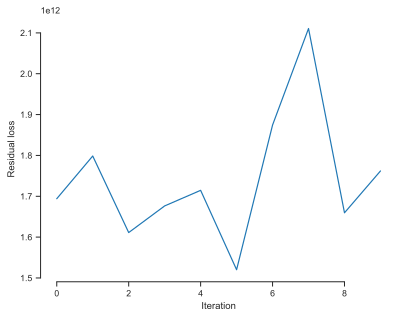

In [77]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Iteration')
ax.set_ylabel('Residual loss')
sns.despine(trim=True);

It's not working! The loss function is not decreasing. Here is also the trained "solution:"

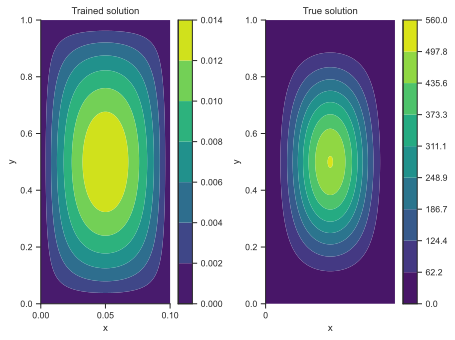

In [78]:
fig, ax = plt.subplots(1,2)
u_pred = v_u_hat(X.flatten(), Y.flatten(), trained_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true, cmap='viridis', levels=jnp.linspace(0, 560, 10))
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('True solution')
sns.despine(trim=True)
plt.tight_layout();

## Non-dimensionalization of Partial Differential Equations

The problem is that the initialization of the network weights is completely off.
Glorot initialization is assuming that the input data and the output data are scaled to be around zero (scale of about 1).
To get our problem to that scale, we need to non-dimensionalize it.

We start by picking characteristic lengthscales.
Here, it makes sense to pick $L_x$ and $L_y$ as characteristic lengthscales.
We also need to pick a characteristic value for the temperature, say $u_s$.

$$
\begin{aligned}
    \tilde{x} = \frac{x}{L_x}, \quad \tilde{y} = \frac{y}{L_y}, \quad \tilde{u} = \frac{u}{u_s}.
\end{aligned}
$$

The next step is to find the partial derivatives of $u$ with respect to $x$ and $y$ in terms of the non-dimensional variables:

$$
\frac{\partial u}{\partial x} = \frac{u_s}{L_x}\frac{\partial \tilde{u}}{\partial \tilde{x}}, \quad \frac{\partial u}{\partial y} = \frac{us}{L_y}\frac{\partial \tilde{u}}{\partial \tilde{y}}.
$$

Here, we just used the chain rule.

The second derivatives are:

$$
\frac{\partial^2 u}{\partial x^2} = \frac{u_s}{L_x^2}\frac{\partial^2 \tilde{u}}{\partial \tilde{x}^2}, \quad \frac{\partial^2 u}{\partial y^2} = \frac{u_s}{L_y^2}\frac{\partial^2 \tilde{u}}{\partial \tilde{y}^2}.
$$

Plugging these into the original PDE, we get:

$$
-k\left(\frac{u_s}{L_x^2}\frac{\partial^2 \tilde{u}}{\partial \tilde{x}^2} + \frac{u_s}{L_y^2}\frac{\partial^2 \tilde{u}}{\partial \tilde{y}^2}\right) = f.
$$
Define now the non-dimensional source term:

$$
\tilde{f} = \frac{f}{f_0}.
$$

And the non-dimensional thermal conductivity:

$$
\tilde{k}_x = \frac{ku_s}{L_x^2 f_0}, \quad \tilde{k}_y = \frac{ku_s}{L_y^2 f_0}.
$$

The equation becomes:

$$
-\left(\tilde{k_x}\frac{\partial^2 \tilde{u}}{\partial \tilde{x}^2} + \tilde{k_y}\frac{\partial^2 \tilde{u}}{\partial \tilde{y}^2}\right) = \tilde{f},
$$

defined on the non-dimensional domain $\tilde{\Omega} = [0, 1]\times [0, 1]$.

Let's visualize both sides for the initial state of our neural network for the choice $u_s = 1$ and $f_0=1$:

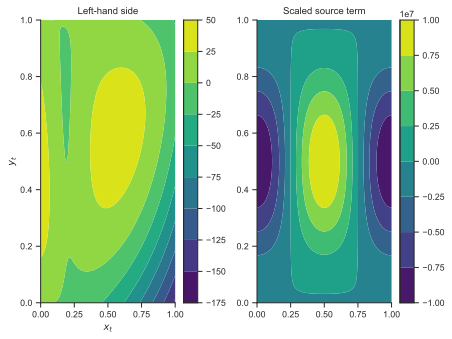

In [148]:
us = 1.0
f0 = 1.0

to_x = lambda xt: xt * Lx
to_y = lambda yt: yt * Ly
to_xt = lambda x: x / Lx
to_yt = lambda y: y / Ly

tmlp = eqx.nn.MLP(2, 1, width_size, depth, jnp.tanh, key=subkey)
tu_hat = lambda tx, ty, tmlp: tx * (1.0 - tx) * ty * (1.0 - ty) * tmlp(jnp.array([tx, ty]))[0]
tu_x = grad(tu_hat, argnums=0)
tu_y = grad(tu_hat, argnums=1)
tu_xx = grad(tu_x, argnums=0)
tu_yy = grad(tu_y, argnums=1)
lhs = lambda tx, ty, tmlp: -k / f0 * (us / Lx ** 2 * tu_xx(tx, ty, tmlp) + us / Ly ** 2 * tu_yy(tx, ty, tmlp))
v_lhs = eqx.filter_jit(vmap(lhs, in_axes=(0, 0, None)))

fig, ax = plt.subplots(1,2)

tl = v_lhs(to_xt(to_xt(X).flatten()), to_yt(to_yt(Y).flatten()), tmlp).reshape(X.shape)
c = ax[0].contourf(to_xt(X), to_yt(Y), tl, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel(r'$x_t$')
ax[0].set_ylabel(r'$y_t$')
ax[0].set_title('Left-hand side')

tf = source_term(X.flatten(), Y.flatten()).reshape(X.shape) / f0
c = ax[1].contourf(to_xt(X), to_yt(Y), f, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[0].set_xlabel(r'$x_t$')
ax[0].set_ylabel(r'$y_t$')
ax[1].set_title('Scaled source term')

sns.despine(trim=True)
plt.tight_layout();

The scale is very different.
We need to pick $u_s$ and $f_0$ so that the scales are similar and close to 1.

We will pick:

$$
f_0 = \max_{(x,y)\in\Omega} |f(x,y)|.
$$

This will make the source term non-dimensionalized to be close to 1.

For $u_s$, it is a bit trickier.
First, let's figure out what are the maximum values of the second derivatives of $u$:

In [134]:
v_tu_xx = eqx.filter_jit(vmap(tu_xx, in_axes=(0, 0, None)))
v_tu_yy = eqx.filter_jit(vmap(tu_yy, in_axes=(0, 0, None)))
(jnp.abs(v_tu_xx(to_xt(X).flatten(), to_yt(Y).flatten(), tmlp)).max(), jnp.abs(v_tu_yy(to_xt(X).flatten(), to_yt(Y).flatten(), tmlp)).max())

(Array(0.04128473, dtype=float32), Array(0.06789896, dtype=float32))

In [150]:
f0 = jnp.abs(tf).max()
f0

Array(9960774., dtype=float32)

In [151]:
#k / f0 * us / Lx ** 2 * 0.04128473 = 1.0
us = 1.0 / k * f0 * Lx ** 2 / 0.04128473
us

Array(241270.19, dtype=float32)

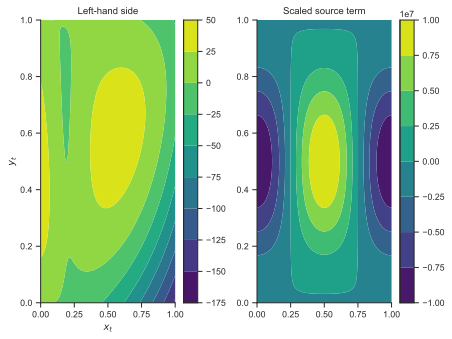

In [152]:
fig, ax = plt.subplots(1,2)

tl = v_lhs(to_xt(to_xt(X).flatten()), to_yt(to_yt(Y).flatten()), tmlp).reshape(X.shape)
c = ax[0].contourf(to_xt(X), to_yt(Y), tl, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel(r'$x_t$')
ax[0].set_ylabel(r'$y_t$')
ax[0].set_title('Left-hand side')

tf = source_term(X.flatten(), Y.flatten()).reshape(X.shape) / f0
c = ax[1].contourf(to_xt(X), to_yt(Y), f, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[0].set_xlabel(r'$x_t$')
ax[0].set_ylabel(r'$y_t$')
ax[1].set_title('Scaled source term')

sns.despine(trim=True)
plt.tight_layout();

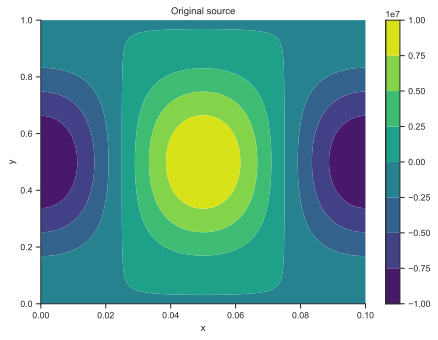

In [96]:
fig, ax = plt.subplots()
# Set aspect ratio to be equal
f = source_term(X.flatten(), Y.flatten()).reshape(X.shape)
c = ax.contourf(X, Y, f, cmap='viridis')
fig.colorbar(c, ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Original source')
sns.despine(trim=True)
plt.tight_layout();

This scale is awful. Let's pick the maximum source term value:

$$
f_0 = \max_{(x, y) \in \Omega} f(x, y):
$$

In [98]:
f0 = jnp.max(f)
print(f0)

9960774.0


Define now the non-dimensional source term:

$$
\tilde{f} = \frac{f}{f_0}.
$$

And the non-dimensional thermal conductivity:

$$
\tilde{k}_x = \frac{ku_s}{L_x^2 f_0}, \quad \tilde{k}_y = \frac{ku_s}{L_y^2 f_0}.
$$

The equation becomes:

$$
-\left(\tilde{k_x}\frac{\partial^2 \tilde{u}}{\partial \tilde{x}^2} + \tilde{k_y}\frac{\partial^2 \tilde{u}}{\partial \tilde{y}^2}\right) = \tilde{f},
$$

defined on the non-dimensional domain $\tilde{\Omega} = [0, 1]\times [0, 1]$.

In [101]:
tkx = (k * us) / (Lx ** 2 * f0)
tky = (k * us) / (Ly ** 2 * f0)
print(f"tkx = {tkx:.3e}, tky = {tky:.3e}") 

tkx = 1.004e-02, tky = 1.004e-04


Let's also compare the original and the scaled source terms:

In [102]:
to_x = lambda xt: xt * Lx
to_y = lambda yt: yt * Ly
to_xt = lambda x: x / Lx
to_yt = lambda y: y / Ly
to_ft = lambda f: f / f0

tilde_soure_term = lambda xt, yt:  to_ft(source_term(to_x(xt), to_y(yt)))

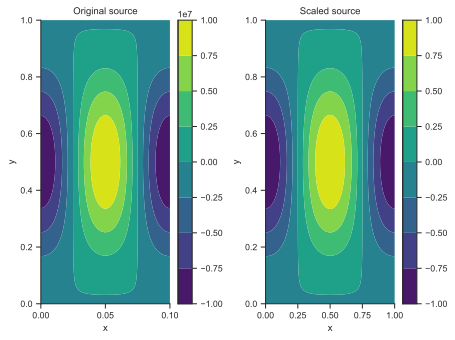

In [103]:
fig, ax = plt.subplots(1,2)
f = source_term(X.flatten(), Y.flatten()).reshape(X.shape)
c = ax[0].contourf(X, Y, f, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Original source')
tf = tilde_soure_term(to_xt(X.flatten()), to_yt(Y.flatten())).reshape(X.shape)
c = ax[1].contourf(to_xt(X), to_yt(Y), tf, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Scaled source')
sns.despine(trim=True)
plt.tight_layout();

The numbers are still large, but not as large as before.

Let's now try training the scaled version of the problem:

In [104]:
tmlp = eqx.nn.MLP(2, 1, width_size, depth, jnp.tanh, key=subkey)
tu_hat = lambda tx, ty, tmlp: tx * (1.0 - tx) * ty * (1.0 - ty) * tmlp(jnp.array([tx, ty]))[0]
tu_x = grad(tu_hat, argnums=0)
tu_y = grad(tu_hat, argnums=1)
tu_xx = grad(tu_x, argnums=0)
tu_yy = grad(tu_y, argnums=1)
tpde_residual = vmap(
    lambda tx, ty, tmlp: tkx * tu_xx(tx, ty, tmlp) + tky * tu_yy(tx, ty, tmlp) + tilde_soure_term(tx, ty),
    in_axes=(0, 0, None))
tloss = lambda tmlp, tx, ty: jnp.mean(jnp.square(tpde_residual(tx, ty, tmlp)))

In [113]:
optimizer = optax.adam(1e-3)
trained_tmlp, losses = train(tloss, tmlp, key, optimizer, num_collocation_residual=256, num_iter=10_000, freq=100, Lx=1.0, Ly=1.0)

Step 0, residual loss 1.707e-01
Step 100, residual loss 1.200e-01
Step 200, residual loss 1.036e-01
Step 300, residual loss 7.889e-02
Step 400, residual loss 1.052e-01
Step 500, residual loss 1.001e-01
Step 600, residual loss 1.081e-01
Step 700, residual loss 1.520e-01
Step 800, residual loss 7.143e-02
Step 900, residual loss 1.093e-01
Step 1000, residual loss 1.035e-01
Step 1100, residual loss 1.289e-01
Step 1200, residual loss 1.099e-01
Step 1300, residual loss 1.100e-01
Step 1400, residual loss 1.090e-01
Step 1500, residual loss 1.093e-01
Step 1600, residual loss 1.081e-01
Step 1700, residual loss 9.068e-02
Step 1800, residual loss 1.057e-01
Step 1900, residual loss 9.714e-02
Step 2000, residual loss 1.231e-01
Step 2100, residual loss 9.128e-02
Step 2200, residual loss 1.103e-01
Step 2300, residual loss 8.734e-02
Step 2400, residual loss 1.174e-01
Step 2500, residual loss 1.027e-01
Step 2600, residual loss 9.311e-02
Step 2700, residual loss 9.446e-02
Step 2800, residual loss 1.233e-

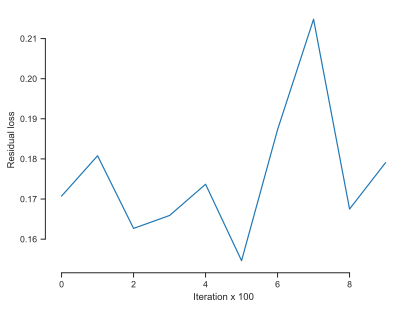

In [111]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Iteration x 100')
ax.set_ylabel('Residual loss')
sns.despine(trim=True);

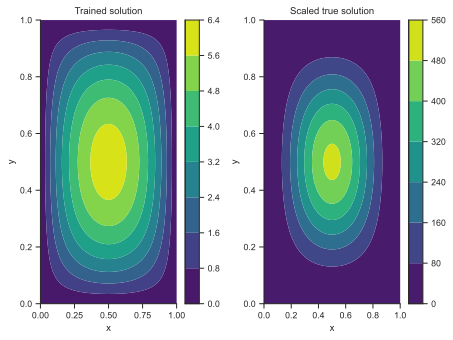

In [112]:
v_tu_hat = vmap(tu_hat, in_axes=(0, 0, None))
fig, ax = plt.subplots(1,2)
u_pred = v_tu_hat(to_xt(X.flatten()), to_yt(Y.flatten()), trained_tmlp).reshape(X.shape)
c = ax[0].contourf(to_xt(X), to_yt(Y), u_pred * us, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(to_xt(X), to_yt(Y), u_true, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Scaled true solution')
sns.despine(trim=True)
plt.tight_layout();